In [ ]:
#| default_exp utils

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# Utils

> The `core.StatsForecast` class allows you to efficiently fit multiple `StatsForecast` models for large sets of time series. It operates with pandas DataFrame `df` that identifies individual series and datestamps with the `unique_id` and `ds` columns, and the `y` column denotes the target time series variable. To assist development, we declare useful datasets that we use throughout all `StatsForecast`'s unit tests.

In [ ]:
#| export
import random
from itertools import chain

import numpy as np
import pandas as pd

from nbdev.showdoc import add_docs, show_doc

In [ ]:
#| hide
import matplotlib.pyplot as plt

# <span style="color:DarkBlue">1. Synthetic Panel Data </span>

In [ ]:
#| export
def generate_series(n_series: int,
                    freq: str = 'D',
                    min_length: int = 50,
                    max_length: int = 500,
                    n_static_features: int = 0,
                    equal_ends: bool = False,
                    seed: int = 0) -> pd.DataFrame:
    """Generate Synthetic Panel Series.

    Generates `n_series` of frequency `freq` of different lengths in the interval [`min_length`, `max_length`].
    If `n_static_features > 0`, then each serie gets static features with random values.
    If `equal_ends == True` then all series end at the same date.

    **Parameters:**<br>
    `n_series`: int, number of series for synthetic panel.<br>
    `min_length`: int, minimal length of synthetic panel's series.<br>
    `max_length`: int, minimal length of synthetic panel's series.<br>
    `n_static_features`: int, default=0, number of static exogenous variables for synthetic panel's series.<br>
    `equal_ends`: bool, if True, series finish in the same date stamp `ds`.<br>
    `freq`: str, frequency of the data, [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).<br>

    **Returns:**<br>
    `freq`: pandas.DataFrame, synthetic panel with columns [`unique_id`, `ds`, `y`] and exogenous.
    """
    seasonalities = {'D': 7, 'M': 12}
    season = seasonalities[freq]
    
    rng = np.random.RandomState(seed)
    series_lengths = rng.randint(min_length, max_length + 1, n_series)
    total_length = series_lengths.sum()

    dates = pd.date_range('2000-01-01', periods=max_length, freq=freq).values
    uids = [
        np.repeat(i, serie_length) for i, serie_length in enumerate(series_lengths)
    ]
    if equal_ends:
        ds = [dates[-serie_length:] for serie_length in series_lengths]
    else:
        ds = [dates[:serie_length] for serie_length in series_lengths]
    y = np.arange(total_length) % season + rng.rand(total_length) * 0.5
    series = pd.DataFrame(
        {
            'unique_id': chain.from_iterable(uids),
            'ds': chain.from_iterable(ds),
            'y': y,
        }
    )
    for i in range(n_static_features):
        random.seed(seed)
        static_values = [
            [random.randint(0, 100)] * serie_length for serie_length in series_lengths
        ]
        series[f'static_{i}'] = np.hstack(static_values)
        series[f'static_{i}'] = series[f'static_{i}'].astype('category')
        if i == 0:
            series['y'] = series['y'] * (1 + series[f'static_{i}'].cat.codes)
    series['unique_id'] = series['unique_id'].astype('category')
    series['unique_id'] = series['unique_id'].cat.as_ordered()
    series = series.set_index('unique_id')
    return series

In [ ]:
show_doc(generate_series, title_level=3)

---

### generate_series

>      generate_series (n_series:int, freq:str='D', min_length:int=50,
>                       max_length:int=500, n_static_features:int=0,
>                       equal_ends:bool=False, seed:int=0)

Generate Synthetic Panel Series.

Generates `n_series` of frequency `freq` of different lengths in the interval [`min_length`, `max_length`].
If `n_static_features > 0`, then each serie gets static features with random values.
If `equal_ends == True` then all series end at the same date.

**Parameters:**<br>
`n_series`: int, number of series for synthetic panel.<br>
`min_length`: int, minimal length of synthetic panel's series.<br>
`max_length`: int, minimal length of synthetic panel's series.<br>
`n_static_features`: int, default=0, number of static exogenous variables for synthetic panel's series.<br>
`equal_ends`: bool, if True, series finish in the same date stamp `ds`.<br>
`freq`: str, frequency of the data, [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).<br>

**Returns:**<br>
`freq`: pandas.DataFrame, synthetic panel with columns [`unique_id`, `ds`, `y`] and exogenous.

In [ ]:
from statsforecast.utils import generate_series

synthetic_panel = generate_series(n_series=2)
synthetic_panel.groupby('unique_id').head(4)

,ds,y
unique_id,,
0,2000-01-01,0.357595
0,2000-01-02,1.301382
0,2000-01-03,2.272442
0,2000-01-04,3.211827
1,2000-01-01,5.399023
1,2000-01-02,6.092818
1,2000-01-03,0.476396
1,2000-01-04,1.343744


# <span style="color:DarkBlue">2. AirPassengers Data </span>

The classic Box & Jenkins airline data. Monthly totals of international airline passengers, 1949 to 1960.

It has been used as a reference on several forecasting libraries, since it is a series that shows clear trends and seasonalities it offers a nice opportunity to quickly showcase a model's predictions performance.

In [ ]:
#| export
AirPassengers = np.array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
                          118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
                          114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
                          162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
                          209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
                          272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
                          302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
                          315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
                          318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
                          348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
                          362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
                          342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
                          417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
                          432.])

In [ ]:
#| export
AirPassengersDF = pd.DataFrame({'unique_id': np.ones(len(AirPassengers)),
                                'ds': pd.date_range(start='1949-01-01',
                                                    periods=len(AirPassengers), freq='M'),
                                'y': AirPassengers})

In [ ]:
from statsforecast.utils import AirPassengersDF

AirPassengersDF.head(12)

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
5,1.0,1949-06-30,135.0
6,1.0,1949-07-31,148.0
7,1.0,1949-08-31,148.0
8,1.0,1949-09-30,136.0
9,1.0,1949-10-31,119.0


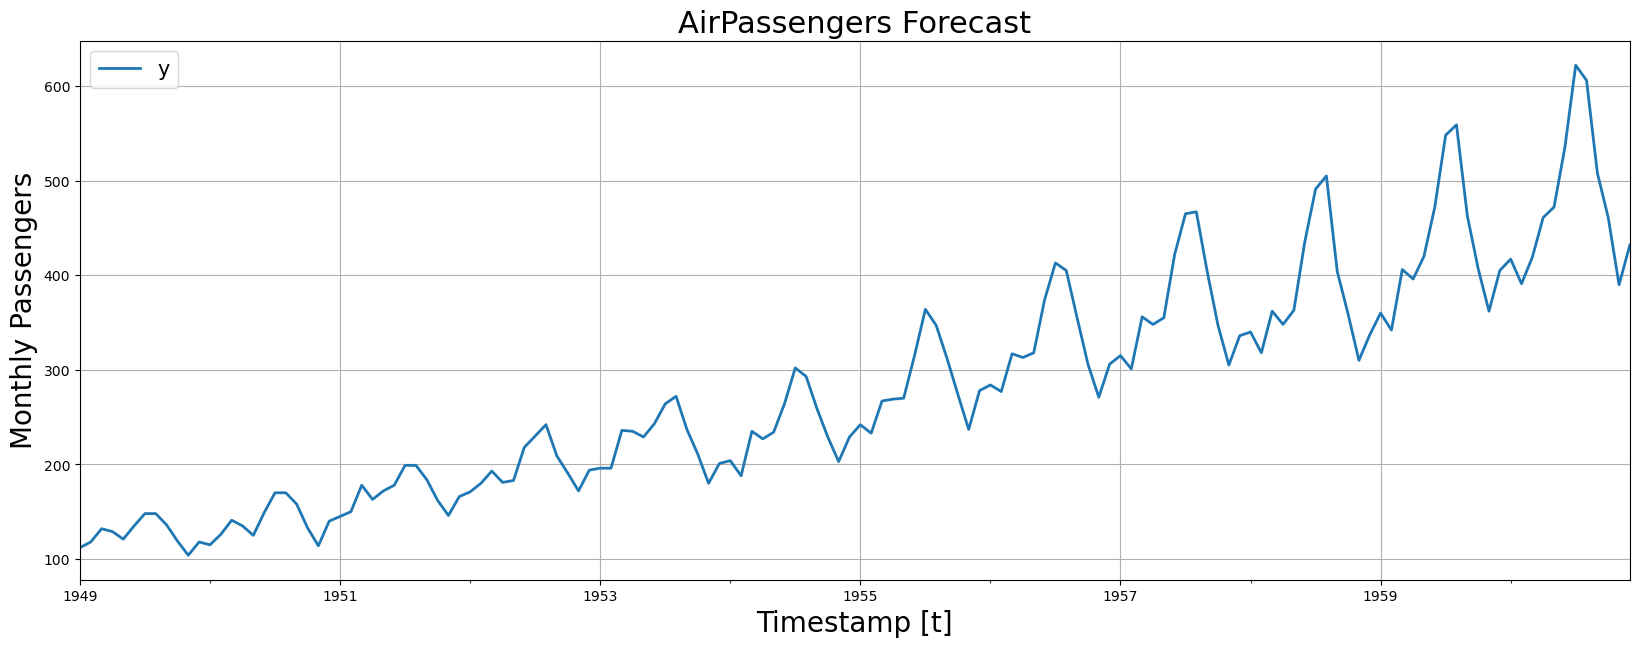

In [ ]:
#We are going to plot the ARIMA predictions, and the prediction intervals.
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = AirPassengersDF.set_index('ds')

plot_df[['y']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()